# Libraries and Data

In [488]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
import skopt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [489]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)
sample = pd.read_csv("../data/sample_submission.csv", low_memory = False)

In [490]:
train.shape, test.shape

((37439, 40), (10000, 39))

In [491]:
train.columns, test.columns

(Index(['Id', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
        'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region', 'Elementary School', 'Elementary School Score',
        'Elementary School Distance', 'Middle School', 'Middle School Score',
        'Middle School Distance', 'High School', 'High School Score',
        'High School Distance', 'Flooring', 'Heating features',
        'Cooling features', 'Appliances included', 'Laundry features',
        'Parking features', 'Tax assessed value', 'Annual tax amount',
        'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
        'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
        'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region',

In [492]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37439 entries, 0 to 37438
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           37439 non-null  int64  
 1   Sold Price                   37439 non-null  int64  
 2   Summary                      37176 non-null  object 
 3   Type                         37439 non-null  object 
 4   Year built                   36686 non-null  float64
 5   Heating                      32481 non-null  object 
 6   Cooling                      29109 non-null  object 
 7   Parking                      36720 non-null  object 
 8   Lot                          26041 non-null  float64
 9   Bedrooms                     35235 non-null  object 
 10  Bathrooms                    34786 non-null  float64
 11  Full bathrooms               31696 non-null  float64
 12  Total interior livable area  35443 non-null  float64
 13  Total spaces    

# Data Pre-Processing

In [493]:
#sns.histplot(np.log(train["Sold Price"]))
#sns.histplot(train["Garage spaces"])
#train["Year built"].unique()
train["High School Distance"].isna().any()

True

## Exploring Heating Variable

In [494]:
asdf = train["Heating"].value_counts()
asdf

Central                                            7280
Central Forced Air                                 4695
Central Forced Air - Gas                           3041
Forced Air                                         1977
Wall Furnace                                       1535
                                                   ... 
Stove - Wood, Other                                   1
Radiant, Daiken Mini Splits                           1
Solar, Central Forced Air - Gas, Radiant Floors       1
Propane, Electric, Wall Furnace, Wood Stove           1
Natural Gas, Electric                                 1
Name: Heating, Length: 1536, dtype: int64

<AxesSubplot:>

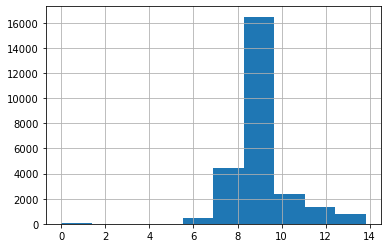

In [495]:
np.log(np.minimum(train["Lot"], 1e6) + 1).hist()

In [496]:
train[train["Lot"].isna()]

,Id,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
1,1,711000,"Modern, Hip, & Bright! This beautifully mainta...",Condo,2016.0,Central,"Air Conditioning, Central",Covered,NaN,2,...,Covered,NaN,NaN,6/23/2020,737000,NaN,NaN,Los Angeles,90020,CA
5,5,196000,HUD Home Opportunity. This 2 Bedroom/ 2 Bath h...,VacantLand,1973.0,Other,Central,"Garage - Attached, Covered",NaN,NaN,...,NaN,145656,1429,11/17/2012,56000,2/26/2018,120000.0,Gerber,96035,CA
9,9,432000,Live in the heart of West Hollywood at one of ...,Condo,1973.0,Central,Central Air,0 spaces,NaN,0,...,NaN,271309,3494,2/26/2020,456000,4/27/2011,225000.0,West Hollywood,90069,CA
12,12,686000,GREAT LOCATION - Near USC and L A Coliseum. 2...,Unknown,1906.0,NaN,NaN,Garage,NaN,NaN,...,Garage,271376,3484,9/23/2019,692000,3/4/1996,145000.0,Los Angeles,90018,CA
14,14,326000,"Smartsville, CA ~ Commute? No problem! This ho...",MobileManufactured,2005.0,Central,"Central Air, Ceiling Fan(s)",Off-street,NaN,3,...,Off-street,316780,3574,11/15/2019,339900,NaN,NaN,Smartsville,95977,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37418,37418,427000,"Gated Complex W/ Large Common Courtyard Area, ...",Condo,1982.0,Central,Whole House Fan,Garage,NaN,2,...,Garage,153905,2096,8/7/2020,449000,8/4/1995,97500.0,Gardena,90248,CA
37423,37423,687000,Prime Location in LA. Center of Mid-Wilshire. ...,Condo,2007.0,Central,Central Air,Garage - Two Door,NaN,3,...,Garage - Two Door,618562,7478,12/20/2019,719000,NaN,NaN,Los Angeles,90006,CA
37424,37424,808000,"In the heart of the city, this two-bedroom con...",Condo,1963.0,Electric,NaN,"Attached, Enclosed, Garage Door Opener, Interi...",NaN,2,...,"Attached, Enclosed, Garage Door Opener, Interi...",630997,8376,8/14/2020,885000,NaN,NaN,San Francisco,94109,CA
37430,37430,942000,Great Investment Opportunity!!!! Four Unit El ...,MultiFamily,1940.0,Wall,NaN,Covered,NaN,8,...,Covered,156325,2715,12/19/2019,1184000,NaN,NaN,Los Angeles,90032,CA


In [497]:
heat_types = train["Heating"].str.lower().str.split(",").explode().str.strip().value_counts().head(30)
heat_types
# h1 = central, forced air, forced, furnace
# h2 = radiant, heat pump, baseboard, steam, zone
# h3 = wood, stove, fireplace, fire, coal, pellet
# h4 = solar, geothermal

central                     9195
forced air                  5999
central forced air          5830
central forced air - gas    3969
gas                         3522
wall furnace                2150
other                       1667
electric                    1438
fireplace                    928
baseboard                    699
natural gas                  678
radiant                      671
heating - 2+ zones           652
propane                      631
fireplace(s)                 469
none                         453
wall                         424
floor furnace                422
heat pump                    365
wood stove                   339
solar                        284
propane / butane             230
radiant floors               219
zoned                        201
stove                        177
wood / pellet                172
stove - wood                 138
forced air - gas             120
see remarks                  117
individual room controls     102
Name: Heat

In [498]:
train[["t1", "t2", "t3", "t4", "t5", "t6"]].corr()

KeyError: "None of [Index(['t1', 't2', 't3', 't4', 't5', 't6'], dtype='object')] are in the [columns]"

In [499]:
train["h3"].value_counts()

KeyError: 'h3'

In [500]:
train["Type"].str.lower().str.replace(" ", "").unique()
# singlefamily
# condo, duplex, triplex, multifamily
# new
# apartment
# luxury, penthouse, rise
# vacant

array(['singlefamily', 'condo', 'townhouse', 'vacantland', 'unknown',
       'mobilemanufactured', 'multifamily', 'cooperative',
       'topfloor,2level', 'apartment', '3story', '4+story',
       '2story,duplex', 'detached,splitlevel', 'duplex',
       'luxury,townhouse,2level',
       'mid-rise(4-8),unitbelow,unitabove,3level',
       'topfloor,2level,low-rise(1-3)', 'detached',
       'topfloor,flat,low-rise(1-3)', 'acreage', 'flat,attached',
       'topfloor,flat,full,unitabove,penthouse', 'mid-rise(4-8),endunit',
       '1level,flat,low-rise(1-3),unitabove', 'mid-rise(4-8)',
       'topfloor,2level,semi-attached', 'residentiallot', 'ranch',
       'luxury,2level', 'mfd-f', 'luxury,mid-rise(4-8)',
       '2story,full,attached', '2level,detached', '3level,live/work',
       'full,semi-attached', 'newconstruction,low-rise(1-3)',
       'hi-rise(9+)', 'triplex', '2story', 'residential',
       'low-rise(1-3),full,unitabove', 'mid-rise(4-8),topfloor,unitbelow',
       'doublewide', 'uni

In [501]:
train["Type"].str.lower().str.replace(" ", "").value_counts().head(50)

singlefamily                            24635
condo                                    6630
townhouse                                2040
unknown                                  1291
multifamily                               987
mobilemanufactured                        801
vacantland                                606
apartment                                 149
cooperative                                34
mfd-f                                      20
residentiallot                             16
2story                                     15
acreage                                    12
duplex                                     11
3story                                      9
manufacturedhome                            7
3story,duplex                               7
31                                          7
mid-rise(4-8)                               6
topfloor                                    6
hi-rise(9+)                                 6
detached,2story                   

In [502]:
train.median()["Sold Price"]

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


1042000.0

Impute missing values for certain numeric variables

In [521]:
train_medians = train.median()
test_medians = test.median()

def preprocess_data(df, meds):
    df["Total interior livable area"] = df["Total interior livable area"].fillna(meds["Total interior livable area"])
    
    df["Bathrooms"] = df["Bathrooms"].fillna(meds["Bathrooms"])
    
    df["Total spaces"] = df["Total spaces"].fillna(meds["Total spaces"])
    df["Total spaces"] = np.abs(np.minimum(df["Total spaces"], 30))
    
    df["High School Score"] = df["High School Score"].fillna(meds["High School Score"])
    df["High School Distance"] = df["High School Distance"].fillna(meds["High School Distance"])

    
    df["Year built"] = df["Year built"].fillna(meds["Year built"])
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    
    df["state_ind"] = df["State"] == "CA"
    
    df["Garage spaces"] = df["Garage spaces"].fillna(meds["Garage spaces"])
    df["Garage spaces"] = np.maximum(df["Garage spaces"], 0)
    df["Garage spaces"] = np.minimum(df["Garage spaces"], 20)
    
    df["Elementary School Score"] = df["Elementary School Score"].fillna(meds["Elementary School Score"])
    
    df["Full bathrooms"] = df["Full bathrooms"].fillna(meds["Full bathrooms"])
  
    df["h1"] = (df["Heating"].str.lower().str.contains("central") | 
                df["Heating"].str.lower().str.contains("forced")  |
                df["Heating"].str.lower().str.contains("furnace") |
                df["Heating"].str.lower().str.contains("air"))
    df["h2"] = df["Heating"].str.lower().str.contains("gas", na=False)
    df["h3"] = df["Heating"].str.lower().str.contains("wall furnace", na=False)
    df["h4"] = (df["Heating"].str.lower().str.contains("solar") | 
                df["Heating"].str.lower().str.contains("geothermal"))
    
    df["t1"] = df["Type"].str.lower().str.replace(" ", "").str.contains("singlefamily")
    df["t2"] = df["Type"].str.lower().str.replace(" ", "").str.contains("condo")
    df["t3"] = df["Type"].str.lower().str.replace(" ", "").str.contains("apartment")
    df["t4"] = df["Type"].str.lower().str.replace(" ", "").str.contains("vacant")
    df["t5"] = (df["Type"].str.lower().str.replace(" ", "").str.contains("plex")  |
                df["Type"].str.lower().str.replace(" ", "").str.contains("multifamily"))
    df["t6"] = df["Type"].str.lower().str.replace(" ", "").str.contains("townhouse")
    df["t7"] = df["Type"].str.lower().str.replace(" ", "").str.contains("mobile")
    df["t8"] = df["Type"].str.lower().str.replace(" ", "").str.contains("unknown")

    
    # Doesn't seem to matter which impute strategy I use
    #df["l1"] = df["Lot"].fillna(meds["Lot"])
    df["l1"] = df["Lot"].fillna(0)
    
    return df

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [522]:
train = preprocess_data(train, train_medians)

Transform the target by logging it since it's got a long right tail

In [524]:
y = np.log(train["Sold Price"])

In [525]:
pred_vars = ["Listed Price", "Total interior livable area", "Bathrooms", 
             "Year built", "High School Score", "Garage spaces", "state_ind", 
            "Elementary School Score", "Full bathrooms", "h1", "h2", "h3", "h4",
            "Total spaces", "High School Distance", "t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8",
            "l1"]

X = train[pred_vars]

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=56)

# Models

In [533]:
params = {"n_estimators":200,
          "learning_rate":0.1,
          "max_depth":4,
          "random_state":56,
          "subsample":1,
          'max_features':None, # None or sqrt
          "loss":'squared_error'}

In [534]:
model = GradientBoostingRegressor().set_params(**params)

In [535]:
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=56,
                          subsample=1)

In [536]:
model.score(X_test, y_test)

0.9316869712467889

<AxesSubplot:>

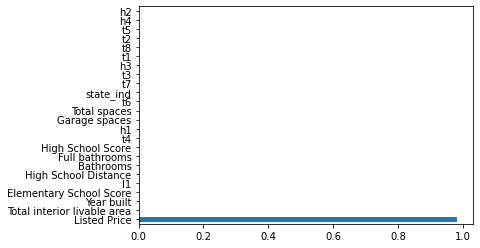

In [537]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(30).plot(kind='barh')

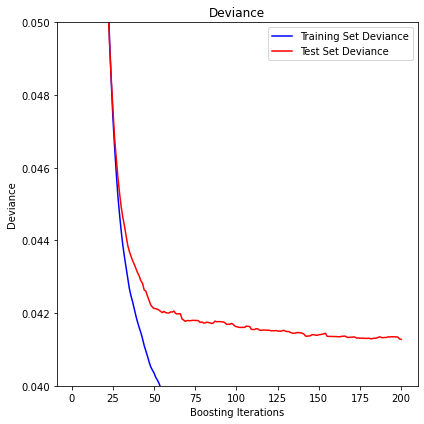

0.041278431311486584


In [538]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.ylim(0.04, 0.05)
fig.tight_layout()
plt.show()
print(np.min(test_score))

# 0.04160437054422551

# Hyperparameter Optimization

In [130]:
BayesSearchCV?

In [135]:
opt = BayesSearchCV(
    GradientBoostingRegressor(random_state = 56,loss = 'squared_error'),
    {
        'n_estimators': (50, 1000),
        'learning_rate': (1e-5, .9, 'log-uniform'),
        'max_depth': (2, 6),  # integer valued parameter
        'subsample': (0.05, 1.0, 'uniform')
    },
    n_iter = 3,
    cv = 3,
    verbose = 1
)

In [136]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  11.3s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.2s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.00016189871380357706, max_depth=6, n_estimators=

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=56),
              n_iter=3,
              search_spaces={'learning_rate': (1e-05, 0.9, 'log-uniform'),
                             'max_depth': (2, 6), 'n_estimators': (50, 1000),
                             'subsample': (0.05, 1.0, 'uniform')},
              verbose=2)

In [35]:
opt.score(X_test, y_test)

# 0.930401 with no subsampling
# 0.929161025403613 with subsampling, 50 iterations


0.9301608507840881

In [36]:
opt.best_estimator_.max_depth, opt.best_estimator_.learning_rate, opt.best_estimator_.n_estimators, opt.best_estimator_.subsample

# (4, 0.019076781177538346, 500, 1.0) with no subsampling
# (5, 0.011876032175591269, 376, 0.44775503528274996) with subsampling (50 iterations)


(4, 0.012474997352881075, 614, 0.3871953641896431)

In [38]:
params["max_depth"] = opt.best_estimator_.max_depth
params["learning_rate"] = opt.best_estimator_.learning_rate
params["n_estimators"] = opt.best_estimator_.n_estimators
params["subsample"] = opt.best_estimator_.subsample

In [99]:
GradientBoostingRegressor?

Train final model with all the data

In [539]:
model = GradientBoostingRegressor().set_params(**params).fit(X, y)

# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [540]:
test = preprocess_data(test, train_medians)
test["Sold Price"] = np.exp(model.predict(test[pred_vars]))

In [541]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)